## Imports

In [3]:
import os
import pickle
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.patches as patches

from PIL import Image, ImageDraw
from ultralytics import YOLO
from ultralyticsplus import render_result
import cv2 as cv

import sys
sys.path.append('RAFT/core')
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
from object_detection_utils import (
    COLORS,
    preprocess, 
    box_cxcywh_to_xyxy, 
    rescale_bboxes,
    batch_detect,
    detect, 
    plot_results,
    plot_batch_detections,
    plot_results_avenue,
    load_images_from_folder,
    list_image_files,
    save_cropped_images,
)

def get_directory_names(parent_directory):
    directory_names = [d for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
    return directory_names

In [5]:
def plot_results_avenue(pil_img, prob, boxes, im_size=(640, 360), display_img=True, save_path=None, crop_objects=False):
    orig_width, orig_height = pil_img.size
    scale_x = orig_width / im_size[0]
    scale_y = orig_height / im_size[1]

    # Create a copy of the image for cropping
    pil_img_copy = pil_img.copy()

    draw = ImageDraw.Draw(pil_img)
    font = ImageFont.load_default()  # Can be changed to another font

    cropped_images = []  # List to hold cropped objects

    for (xmin, ymin, xmax, ymax), c in zip(boxes, COLORS * 100):
        xmin, xmax = xmin * scale_x, xmax * scale_x
        ymin, ymax = ymin * scale_y, ymax * scale_y

        color = tuple(int(255 * x) for x in c)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)

        if crop_objects:
            # Cropping from the unaltered image copy
            cropped_obj = pil_img_copy.crop((xmin, ymin, xmax, ymax))
            cropped_images.append(cropped_obj)

        # Optionally add class text
        # cl = p.argmax()
        # text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        # draw.text((xmin, ymin), text, fill=color, font=font)

    if display_img:
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        plt.axis('off')
        plt.show()

    if save_path:
        pil_img.save(save_path)

    return pil_img, cropped_images

In [6]:
def imshow(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    # img = std * img + mean  # unnormalize
    # img = np.clip(img, 0, 1)  # clip any values outside the range [0, 1]
    plt.imshow(img)
    plt.show()

In [7]:
# Function to preprocess and return numpy array from tensor
def process_image(tensor):
    np_image = tensor.squeeze(0).detach().cpu().numpy()
    if np_image.ndim == 3 and np_image.shape[0] in [3, 4]:  # for RGB or RGBA
        np_image = np_image.transpose(1, 2, 0)
    return np_image

In [8]:
def find_bounding_boxes(orig_image, seg_map, threshold=200, min_area_threshold=200, debug=False):
    """
    Find bounding boxes of objects in an image based on a threshold.
    
    Parameters:
    image (numpy array): The input image.
    threshold (int): Threshold value for binary segmentation.
    min_area_threshold (int): Minimum area threshold for considering an object.
    debug (bool): If True, show the image with detected objects.
    
    Returns:
    List of bounding boxes in the format [xmin, ymin, xmax, ymax].
    """
    drawable = orig_image.copy()
    image = seg_map.astype(np.uint8)
    # Convert the image to grayscale if it's colored
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

    # Apply a binary threshold to the image
    _, binary_image = cv.threshold(gray_image, threshold, 255, cv.THRESH_BINARY)

    # # Define kernel for morphological operations
    # kernel = np.ones((7, 7), np.uint8)

    # # Apply erosion and dilation
    # binary_image = cv.erode(binary_image, kernel, iterations=1)
    # binary_image = cv.dilate(binary_image, kernel, iterations=1)

    # Find connected components
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(binary_image, connectivity=8)

    bounding_boxes = []
    for i in range(1, num_labels):  # Skip label 0 as it's the background
        x, y, w, h, area = stats[i]
        # Check if the area of the blob is greater than the minimum threshold
        if area > min_area_threshold:
            xmin, ymin, xmax, ymax = x, y, x + w, y + h
            bounding_boxes.append([xmin, ymin, xmax, ymax])

            if debug:
                # Draw a rectangle and centroid for visualization
                cv.rectangle(drawable, (xmin, ymin), (xmax, ymax), (0, 0, 255), 3)
                cx, cy = centroids[i]
                cv.circle(drawable, (int(cx), int(cy)), 5, (0, 255, 0), -1)

    if debug:
        # Show the image with detected objects
         # plt.imshow(drawable)

        # Create a figure with 2x2 grid of axes
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot each image on its respective axes
        axs[0].imshow(binary_image)
        axs[0].axis('off')  # Turn off axis
        axs[0].set_title('Binary Image (raw)')
        
        axs[1].imshow(drawable)
        axs[1].axis('off')
        axs[1].set_title('Original image with bounding boxes')

    return bounding_boxes

## RAFT

In [9]:
def process_img(img, device='cuda'):
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)


def load_model(weights_path, args):
    """ Loads model to CUDA only """
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model


def inference(model, frame1, frame2, device='cuda', pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
          flow_low, flow_up = model(frame1,
                                    frame2,
                                    iters=iters,
                                    flow_init=flow_init,
                                    upsample=upsample,
                                    test_mode=test_mode)
          return flow_low, flow_up

        else:
            flow_iters = model(frame1,
                               frame2,
                               iters=iters,
                               flow_init=flow_init,
                               upsample=upsample,
                               test_mode=test_mode)

            return flow_iters


def get_viz(flo):
    flo = flo[0].permute(1,2,0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

In [10]:
# class to interface with RAFT
class Args():
  def __init__(self, model='', path='', small=False, 
               mixed_precision=False, alternate_corr=False):
    self.model = model
    self.path = path
    self.small = small
    self.mixed_precision = mixed_precision
    self.alternate_corr = alternate_corr

  """ Sketchy hack to pretend to iterate through the class objects """
  def __iter__(self):
    return self

  def __next__(self):
    raise StopIteration

#### Benchmark

```
raft-sintel.pth -> 32.6ms to compute flow between 2 frames -> 27fps
raft-small.pth -> 25.4ms to compute flow between 2 frames -> 40fps
```

In [9]:
# # Normal Model
# # model = load_model("RAFT/models/raft-sintel.pth", args=Args())

# # Small Model
# class Args():
#   def __init__(self, model='', path='', small=True, 
#                mixed_precision=True, alternate_corr=False):
#     self.model = model
#     self.path = path
#     self.small = small
#     self.mixed_precision = mixed_precision
#     self.alternate_corr = alternate_corr

#   """ Sketchy hack to pretend to iterate through the class objects """
#   def __iter__(self):
#     return self

#   def __next__(self):
#     raise StopIteration

# model = load_model("RAFT/models/raft-small.pth", args=Args())

# model = model.to(device) # Redundant, but to be sure
# model.eval()

In [10]:
# %%timeit -n 100
# # benchmark
# with torch.no_grad():
#     # Run the model on the batch
#     flow_low, flow_up = inference(model, np.array(frame1), np.array(frame2), device='cuda', test_mode=True)

### Example: Constructing Bounding boxes from Flow

In [11]:
model = load_model("RAFT/models/raft-sintel.pth", args=Args())
model = model.to(device)
model.eval()

DataParallel(
  (module): RAFT(
    (fnet): BasicEncoder(
      (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu1): ReLU(inplace=True)
      (layer1): Sequential(
        (0): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (1): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
          (n

In [12]:
# Read 2 frames
transform = T.Compose([
    # T.Resize((500, 500)),  # Assuming 800 is the input size for the model
    T.ToTensor(),
    # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#### Avenue Example

In [40]:
# image_tensor, image = preprocess("./datasets/Avenue Dataset/test__/02/0288.jpg", transform=transform)

image_tensor, frame1 = preprocess("./datasets/Avenue Dataset/test__/02/0290.jpg", transform=transform)
image_tensor, frame2 = preprocess("./datasets/Avenue Dataset/test__/02/0292.jpg", transform=transform)

In [41]:
flow_low, flow_up = inference(model, np.array(frame1), np.array(frame2), device='cuda', test_mode=True)

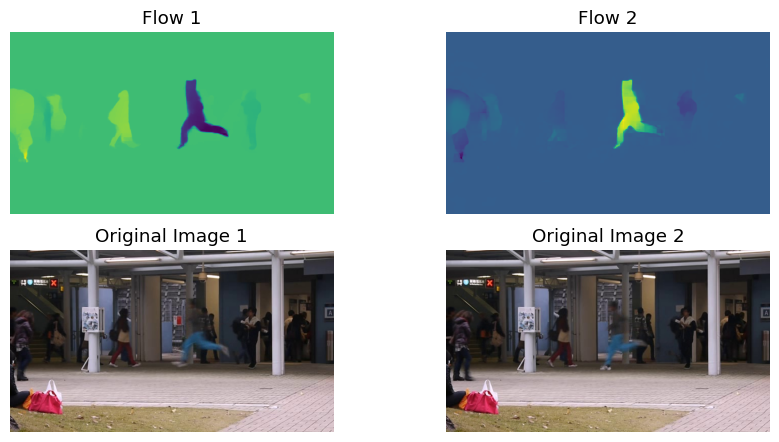

In [42]:
%matplotlib inline
# Process all images
np_seg_map1 = process_image(flow_up.squeeze(0)[0])
np_seg_map2 = process_image(flow_up.squeeze(0)[1])
np_orig_image1 = np.array(frame1)
np_orig_image2 = np.array(frame2)

# Create a figure with 2x2 grid of axes
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot each image on its respective axes
axs[0, 0].imshow(np_seg_map1)
axs[0, 0].axis('off')  # Turn off axis
axs[0, 0].set_title('Flow 1')

axs[0, 1].imshow(np_seg_map2)
axs[0, 1].axis('off')
axs[0, 1].set_title('Flow 2')

axs[1, 0].imshow(np_orig_image1)
axs[1, 0].axis('off')
axs[1, 0].set_title('Original Image 1')

axs[1, 1].imshow(np_orig_image2)
axs[1, 1].axis('off')
axs[1, 1].set_title('Original Image 2')


# Adjust the spacing
plt.subplots_adjust(left=0.1, right=0.9, top=0.5, bottom=0.1, hspace=0.2, wspace=0.2)

# Display the figure
plt.show()

4870
2433
895
[[329, 93, 432, 232], [456, 116, 496, 233], [67, 136, 82, 216]]


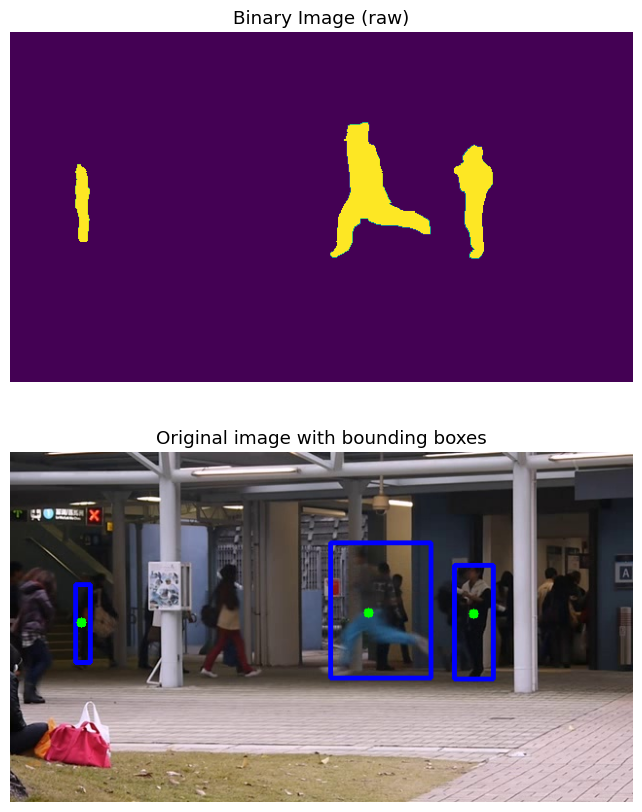

In [43]:
# Example usage
threshold_avenue = 200
bounding_boxes = find_bounding_boxes(np_orig_image1, np_seg_map1, threshold=threshold_avenue, min_area_threshold=200, debug=True)
print(bounding_boxes)

#### Shanghaitech Example

In [13]:
# image_tensor, frame1 = preprocess("./datasets/shanghaitech/testing/frames/02_0128/347.jpg", transform=transform)
# image_tensor, frame2 = preprocess("./datasets/shanghaitech/testing/frames/02_0128/349.jpg", transform=transform)

image_tensor, frame1 = preprocess("./datasets/shanghaitech/testing/frames/01_0134/278.jpg", transform=transform)
image_tensor, frame2 = preprocess("./datasets/shanghaitech/testing/frames/01_0134/300.jpg", transform=transform)

In [14]:
flow_low, flow_up = inference(model, np.array(frame1), np.array(frame2), device='cuda', iters=50, test_mode=True)

/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [19]:
# flow_iters = inference(model, np.array(frame1), np.array(frame2), device='cuda', iters=50, test_mode=False)

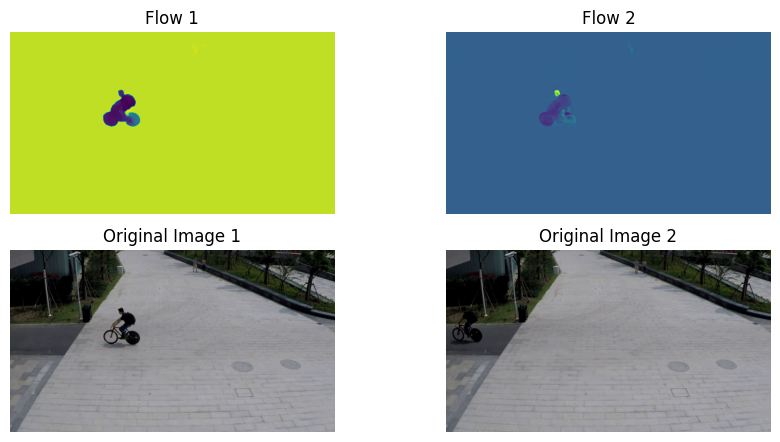

In [15]:
%matplotlib inline
# Process all images
np_seg_map1 = process_image(flow_up.squeeze(0)[0])
# np_seg_map1 = process_image(flow_iters[-1].squeeze(0)[0])

np_seg_map2 = process_image(flow_up.squeeze(0)[1])
# np_seg_map2 =  process_image(flow_iters[-1].squeeze(0)[1])

np_orig_image1 = np.array(frame1)
# np_orig_image1 = flow_iters[-1]
np_orig_image2 = np.array(frame2)

# Create a figure with 2x2 grid of axes
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot each image on its respective axes
axs[0, 0].imshow(np_seg_map1)
axs[0, 0].axis('off')  # Turn off axis
axs[0, 0].set_title('Flow 1')

axs[0, 1].imshow(np_seg_map2)
axs[0, 1].axis('off')
axs[0, 1].set_title('Flow 2')

axs[1, 0].imshow(np_orig_image1)
axs[1, 0].axis('off')
axs[1, 0].set_title('Original Image 1')

axs[1, 1].imshow(np_orig_image2)
axs[1, 1].axis('off')
axs[1, 1].set_title('Original Image 2')


# Adjust the spacing
plt.subplots_adjust(left=0.1, right=0.9, top=0.5, bottom=0.1, hspace=0.2, wspace=0.2)

# Display the figure
plt.show()

[[475, 26, 495, 58], [496, 31, 500, 32], [503, 31, 517, 42], [244, 148, 343, 256]]


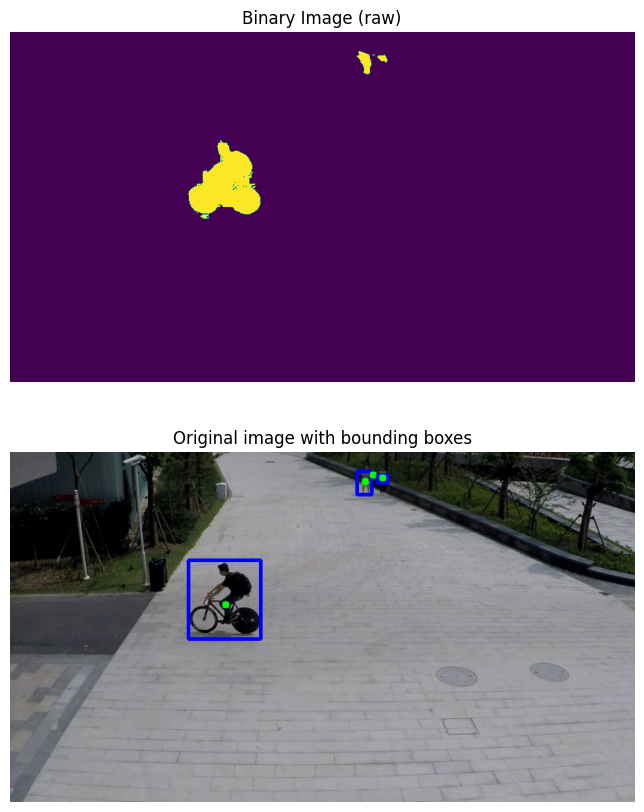

In [21]:
# Example usage
threshold_shanghai = 0
bounding_boxes = find_bounding_boxes(np_orig_image1, np_seg_map1, threshold=threshold_shanghai, min_area_threshold=0, debug=True)
print(bounding_boxes)

### UBNormal example

In [16]:
# image_tensor, frame1 = preprocess("./datasets/shanghaitech/testing/frames/02_0128/347.jpg", transform=transform)
# image_tensor, frame2 = preprocess("./datasets/shanghaitech/testing/frames/02_0128/349.jpg", transform=transform)

image_tensor, frame1 = preprocess("./datasets/UBNormal/test/test_abnormal_frames/abnormal_scene_3_scenario_1/abnormal_scene_3_scenario_1_0117.jpg", transform=transform)
image_tensor, frame2 = preprocess("./datasets/UBNormal/test/test_abnormal_frames/abnormal_scene_3_scenario_1/abnormal_scene_3_scenario_1_0127.jpg", transform=transform)

In [17]:
flow_low, flow_up = inference(model, np.array(frame1), np.array(frame2), device='cuda', iters=20, test_mode=True)

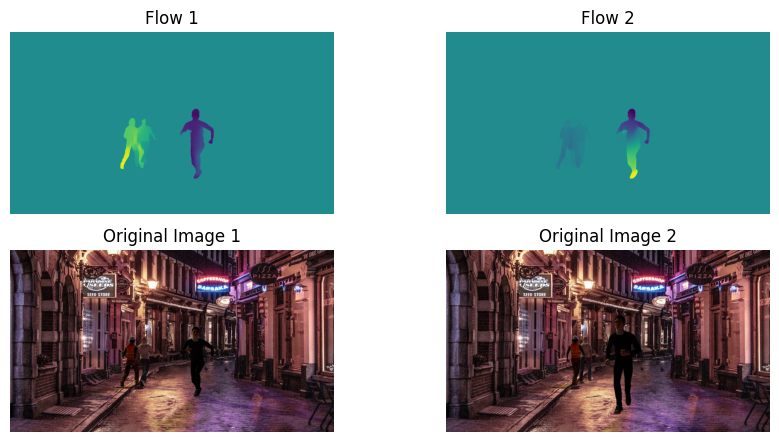

In [18]:
%matplotlib inline
# Process all images
np_seg_map1 = process_image(flow_up.squeeze(0)[0])
# np_seg_map1 = process_image(flow_iters[-1].squeeze(0)[0])

np_seg_map2 = process_image(flow_up.squeeze(0)[1])
# np_seg_map2 =  process_image(flow_iters[-1].squeeze(0)[1])

np_orig_image1 = np.array(frame1)
# np_orig_image1 = flow_iters[-1]
np_orig_image2 = np.array(frame2)

# Create a figure with 2x2 grid of axes
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot each image on its respective axes
axs[0, 0].imshow(np_seg_map1)
axs[0, 0].axis('off')  # Turn off axis
axs[0, 0].set_title('Flow 1')

axs[0, 1].imshow(np_seg_map2)
axs[0, 1].axis('off')
axs[0, 1].set_title('Flow 2')

axs[1, 0].imshow(np_orig_image1)
axs[1, 0].axis('off')
axs[1, 0].set_title('Original Image 1')

axs[1, 1].imshow(np_orig_image2)
axs[1, 1].axis('off')
axs[1, 1].set_title('Original Image 2')


# Adjust the spacing
plt.subplots_adjust(left=0.1, right=0.9, top=0.5, bottom=0.1, hspace=0.2, wspace=0.2)

# Display the figure
plt.show()

### Avenue File Setup

In [20]:
train_dir = "./datasets/Avenue Dataset/train__/"
train_video_dirs = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16"]
train_video_paths = []
total_frames = 0
for dir in train_video_dirs:
    cur_dir = os.path.join(train_dir, dir)
    train_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")

./datasets/Avenue Dataset/train__/01 1364
./datasets/Avenue Dataset/train__/02 1511
./datasets/Avenue Dataset/train__/03 1487
./datasets/Avenue Dataset/train__/04 1511
./datasets/Avenue Dataset/train__/05 815
./datasets/Avenue Dataset/train__/06 1511
./datasets/Avenue Dataset/train__/07 1099
./datasets/Avenue Dataset/train__/08 1017
./datasets/Avenue Dataset/train__/09 1391
./datasets/Avenue Dataset/train__/10 1223
./datasets/Avenue Dataset/train__/11 781
./datasets/Avenue Dataset/train__/12 145
./datasets/Avenue Dataset/train__/13 366
./datasets/Avenue Dataset/train__/14 510
./datasets/Avenue Dataset/train__/15 353
./datasets/Avenue Dataset/train__/16 244
Total Frames: 15328


In [21]:
test_dir = "./datasets/Avenue Dataset/test__/"
test_video_dirs = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21"]
test_video_paths = []
total_frames = 0
for dir in test_video_dirs:
    cur_dir = os.path.join(test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")

./datasets/Avenue Dataset/test__/01 1439
./datasets/Avenue Dataset/test__/02 1211
./datasets/Avenue Dataset/test__/03 923
./datasets/Avenue Dataset/test__/04 947
./datasets/Avenue Dataset/test__/05 1007
./datasets/Avenue Dataset/test__/06 1283
./datasets/Avenue Dataset/test__/07 605
./datasets/Avenue Dataset/test__/08 36
./datasets/Avenue Dataset/test__/09 1175
./datasets/Avenue Dataset/test__/10 841
./datasets/Avenue Dataset/test__/11 472
./datasets/Avenue Dataset/test__/12 1271
./datasets/Avenue Dataset/test__/13 549
./datasets/Avenue Dataset/test__/14 507
./datasets/Avenue Dataset/test__/15 1001
./datasets/Avenue Dataset/test__/16 740
./datasets/Avenue Dataset/test__/17 426
./datasets/Avenue Dataset/test__/18 294
./datasets/Avenue Dataset/test__/19 248
./datasets/Avenue Dataset/test__/20 273
./datasets/Avenue Dataset/test__/21 76
Total Frames: 15324


In [22]:
preds_path = "./datasets/Avenue Dataset/predictions/"
train_preds_path = os.path.join(preds_path, "train/")
test_preds_path = os.path.join(preds_path, "test/")
print(train_preds_path, test_preds_path)

./datasets/Avenue Dataset/predictions/train/ ./datasets/Avenue Dataset/predictions/test/


In [23]:
objects_path = "./datasets/Avenue Dataset/objects/"
train_objects_path = os.path.join(objects_path, "train/")
test_objects_path = os.path.join(objects_path, "test/")
print(train_objects_path, test_objects_path)

./datasets/Avenue Dataset/objects/train/ ./datasets/Avenue Dataset/objects/test/


In [24]:
image_names = [img.split('/')[-1] for img in list_image_files(test_video_paths[-1])]
print(image_names)

['00.jpg', '01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg', '06.jpg', '07.jpg', '08.jpg', '09.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg']


### Shanghaitech File Setup

In [19]:
train_dir = "./datasets/shanghaitech/training/frames/"

# Example usage
train_video_dirs = get_directory_names(train_dir)
print(train_video_dirs[:5])

train_video_paths = []
total_frames = 0
for dir in train_video_dirs:
    cur_dir = os.path.join(train_dir, dir)
    train_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}") # 274515

['01_001', '01_002', '01_003', '01_004', '01_005']
./datasets/shanghaitech/training/frames/01_001 764
./datasets/shanghaitech/training/frames/01_002 481
./datasets/shanghaitech/training/frames/01_003 768
./datasets/shanghaitech/training/frames/01_004 769
./datasets/shanghaitech/training/frames/01_005 673
./datasets/shanghaitech/training/frames/01_006 505
./datasets/shanghaitech/training/frames/01_007 577
./datasets/shanghaitech/training/frames/01_008 1009
./datasets/shanghaitech/training/frames/01_009 859
./datasets/shanghaitech/training/frames/01_010 860
./datasets/shanghaitech/training/frames/01_011 737
./datasets/shanghaitech/training/frames/01_012 737
./datasets/shanghaitech/training/frames/01_013 737
./datasets/shanghaitech/training/frames/01_014 737
./datasets/shanghaitech/training/frames/01_015 739
./datasets/shanghaitech/training/frames/01_016 601
./datasets/shanghaitech/training/frames/01_017 840
./datasets/shanghaitech/training/frames/01_018 841
./datasets/shanghaitech/traini

In [20]:
test_dir = "./datasets/shanghaitech/testing/frames/"

# Example usage
test_video_dirs = get_directory_names(test_dir)
print(test_video_dirs[:5])

test_video_paths = []
total_frames = 0
for dir in test_video_dirs:
    cur_dir = os.path.join(test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}") # 40791

['01_0014', '01_0015', '01_0016', '01_0025', '01_0026']
./datasets/shanghaitech/testing/frames/01_0014 265
./datasets/shanghaitech/testing/frames/01_0015 433
./datasets/shanghaitech/testing/frames/01_0016 337
./datasets/shanghaitech/testing/frames/01_0025 601
./datasets/shanghaitech/testing/frames/01_0026 505
./datasets/shanghaitech/testing/frames/01_0027 409
./datasets/shanghaitech/testing/frames/01_0028 457
./datasets/shanghaitech/testing/frames/01_0029 313
./datasets/shanghaitech/testing/frames/01_0030 409
./datasets/shanghaitech/testing/frames/01_0051 337
./datasets/shanghaitech/testing/frames/01_0052 337
./datasets/shanghaitech/testing/frames/01_0053 457
./datasets/shanghaitech/testing/frames/01_0054 577
./datasets/shanghaitech/testing/frames/01_0055 313
./datasets/shanghaitech/testing/frames/01_0056 529
./datasets/shanghaitech/testing/frames/01_0063 193
./datasets/shanghaitech/testing/frames/01_0064 289
./datasets/shanghaitech/testing/frames/01_0073 289
./datasets/shanghaitech/te

In [21]:
preds_path = "./datasets/shanghaitech/predictions/"
train_preds_path = os.path.join(preds_path, "train/")
test_preds_path = os.path.join(preds_path, "test/")
# create_directories(train_preds_path, train_video_dirs)

In [22]:
objects_path = "./datasets/shanghaitech/objects/"
train_objects_path = os.path.join(objects_path, "train/")
test_objects_path = os.path.join(objects_path, "test/")
# create_directories(train_objects_path, train_video_dirs)

In [23]:
image_names = [img.split('/')[-1] for img in list_image_files(test_video_paths[-1])]
print(image_names[:5])

['000.jpg', '001.jpg', '002.jpg', '003.jpg', '004.jpg']


#### UBNormal File Setup

In [24]:
test_dir = "./datasets/UBNormal/test/"
normal_test_dir = os.path.join(test_dir, 'test_normal_frames/')
abnormal_test_dir = os.path.join(test_dir, 'test_abnormal_frames/')

test_video_dirs = get_directory_names(normal_test_dir)
ab_test_dirs = get_directory_names(abnormal_test_dir)


# test_video_paths = []
# total_frames = 0
# for dir in test_video_dirs:
#     cur_dir = os.path.join(test_dir, dir)
#     test_video_paths.append(cur_dir)
#     jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
#     total_frames += len(jpg_files)
#     print(cur_dir, len(jpg_files))

test_video_paths = []
total_frames = 0
for dir in test_video_dirs:
    cur_dir = os.path.join(normal_test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))

for dir in ab_test_dirs:
    cur_dir = os.path.join(abnormal_test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))

test_video_dirs.extend(ab_test_dirs)

print(len(test_video_paths))  # 211
print(f"Total Frames: {total_frames}") # 92640
video_names = test_video_dirs

./datasets/UBNormal/test/test_normal_frames/normal_scene_10_scenario_2 451
./datasets/UBNormal/test/test_normal_frames/normal_scene_10_scenario_3 451
./datasets/UBNormal/test/test_normal_frames/normal_scene_10_scenario_8 451
./datasets/UBNormal/test/test_normal_frames/normal_scene_10_scenario_9 431
./datasets/UBNormal/test/test_normal_frames/normal_scene_11_scenario_2_fog 451
./datasets/UBNormal/test/test_normal_frames/normal_scene_11_scenario_4_fog 451
./datasets/UBNormal/test/test_normal_frames/normal_scene_12_scenario_2 451
./datasets/UBNormal/test/test_normal_frames/normal_scene_13_scenario_1_fog 451
./datasets/UBNormal/test/test_normal_frames/normal_scene_14_scenario_2 451
./datasets/UBNormal/test/test_normal_frames/normal_scene_14_scenario_4 451
./datasets/UBNormal/test/test_normal_frames/normal_scene_15_scenario_6 451
./datasets/UBNormal/test/test_normal_frames/normal_scene_17_scenario_2 451
./datasets/UBNormal/test/test_normal_frames/normal_scene_17_scenario_3_1 451
./datasets/

In [25]:
preds_path = "./datasets/UBNormal/"
train_preds_path = os.path.join(preds_path, "train_normal_predictions/")
test_preds_path = os.path.join(preds_path, "test/predictions/")
# create_directories(train_preds_path, train_video_dirs)

In [26]:
objects_path = "./datasets/UBNormal/"
train_objects_path = os.path.join(objects_path, "train_normal_objects/")
test_objects_path = os.path.join(objects_path, "test_normal_objects/")
# create_directories(train_objects_path, train_video_dirs)

### Optical Flow Object Detection (I+2)
```
Case I: i i+1 i+2 |

Case II: i i+1 | (no i + 2)

Case III: i | (no i+1, no i+2)
```

In [78]:
%%time

############################ CHANGE BASED ON DATASET

############ Avenue
# pixel_threshold=200 # 200
# im_size = (640, 360)

############ Shanghaitech
pixel_threshold = 0
im_size = (856, 480)

###################################

min_area_threshold=300

transform = T.Compose([
    T.Resize(im_size),
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
])
bbox_temp = {}
video_names = [video.split('/')[-1] for video in test_video_paths]
print(video_names)
obj_dect_opt_flow = {}

# iterate every 2 frames in test set
for i, video_path in enumerate(test_video_paths):

    print(video_path)
    image_names = [img.split('/')[-1] for img in list_image_files(test_video_paths[i])]
    bbox_temp = {}

    frame_idx = 0
    for frame_idx in range(0, len(image_names), 2):

        # Re-init frame variables
        image_fr1 = image_fr2 = None
       
        # Get frame at frame_idx
        full_image_path_fr1 = os.path.join(test_video_paths[i], image_names[frame_idx])
        image_tensor_fr1, image_fr1 = preprocess(full_image_path_fr1, transform=transform)

        # Get frame at frame_idx + 2
        try:
            full_image_path_fr2 = os.path.join(test_video_paths[i], image_names[frame_idx+2])
            image_tensor_fr2, image_fr2 = preprocess(full_image_path_fr2, transform=transform)
        except:
            pass

        # if frame at frame_idx + 2 is None, get frame_idx + 1
        if image_fr2 is None:
            try:
                full_image_path_fr2 = os.path.join(test_video_paths[i], image_names[frame_idx+1])
                image_tensor_fr2, image_fr2 = preprocess(full_image_path_fr2, transform=transform)
            except:
                pass

            # if frame at frame_idx + 1 is None, it means we're at the last frame in the video
            if image_fr2 is None:

                # Set bounding boxes for current frame as previous frame and break
                bbox_temp[frame_idx] = bounding_boxes 
                obj_dect_opt_flow[video_names[i]] = bbox_temp
                
                continue

        # Get optical flow for frame frame_idx, and frame_idx+2
        _, flow_up = inference(model, np.array(image_fr1), np.array(image_fr2), iters=50, device='cuda', test_mode=True)
        # flow_iters = inference(model, np.array(image_fr1), np.array(image_fr2), device='cuda', iters=50, test_mode=True)
        
        # Process all images
        np_seg_map1 = process_image(flow_up.squeeze(0)[0])
        # np_seg_map1 = process_image(flow_iters[-1].squeeze(0)[0])
        # np_seg_map2 = process_image(flow_up.squeeze(0)[1])
        np_orig_image1 = np.array(image_fr1)
        # np_orig_image2 = np.array(image_fr2)

        # Get bounding boxes for frame i
        bounding_boxes = find_bounding_boxes(
            np_orig_image1, 
            np_seg_map1,
            threshold = pixel_threshold,
            min_area_threshold = min_area_threshold,
            debug=False
        )

        bbox_temp[frame_idx] = bounding_boxes
        bbox_temp[frame_idx+1] = bounding_boxes
    
    # Assign same bounding boxes to frame i+1 as in frame i
    obj_dect_opt_flow[video_names[i]] = bbox_temp

['01_0014', '01_0015', '01_0016', '01_0025', '01_0026', '01_0027', '01_0028', '01_0029', '01_0030', '01_0051', '01_0052', '01_0053', '01_0054', '01_0055', '01_0056', '01_0063', '01_0064', '01_0073', '01_0076', '01_0129', '01_0130', '01_0131', '01_0132', '01_0133', '01_0134', '01_0135', '01_0136', '01_0138', '01_0139', '01_0140', '01_0141', '01_0162', '01_0163', '01_0177', '02_0128', '02_0161', '02_0164', '03_0031', '03_0032', '03_0033', '03_0035', '03_0036', '03_0039', '03_0041', '03_0059', '03_0060', '03_0061', '04_0001', '04_0003', '04_0004', '04_0010', '04_0011', '04_0012', '04_0013', '04_0046', '04_0050', '05_0017', '05_0018', '05_0019', '05_0020', '05_0021', '05_0022', '05_0023', '05_0024', '06_0144', '06_0145', '06_0147', '06_0150', '06_0153', '06_0155', '07_0005', '07_0006', '07_0007', '07_0008', '07_0009', '07_0047', '07_0048', '07_0049', '08_0044', '08_0058', '08_0077', '08_0078', '08_0079', '08_0080', '08_0156', '08_0157', '08_0158', '08_0159', '08_0178', '08_0179', '09_0057'

### Optical Flow Object Detection (I+n)
- We'll actually compute optical flow on the difference between i and i+3, but we'll actually iterate i, i+2, etc.

In [59]:
%%time
# 30, 27, 25, 20, 15, 10
############################ CHANGE BASED ON DATASET

############ Avenue
# pixel_threshold=200 # 200
# im_size = (640, 360)
# min_area_threshold = 200
############ Shanghaitech
pixel_threshold = 0
# im_size = (856, 480)
min_area_threshold=0
###################################

transform = T.Compose([
    # T.Resize(im_size),
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
])
bbox_temp = {}
video_names = [video.split('/')[-1] for video in test_video_paths]
print(video_names[:3])
obj_dect_opt_flow = {}
look_ahead = 3

# iterate every 2 frames in test set
for i, video_path in enumerate(test_video_paths):

    print(video_path)
    image_names = [img.split('/')[-1] for img in list_image_files(test_video_paths[i])]
    bbox_temp = {}

    frame_idx = 0
    # Iterate every 2 frames
    for frame_idx in range(0, len(image_names), 2):

        # Re-init frame variables
        image_fr1 = image_fr2 = None
       
        # Get frame at frame_idx
        full_image_path_fr1 = os.path.join(test_video_paths[i], image_names[frame_idx])
        image_tensor_fr1, image_fr1 = preprocess(full_image_path_fr1, transform=transform)

        # Try to get frame at frame_idx + lookahead
        try:
            full_image_path_fr2 = os.path.join(test_video_paths[i], image_names[frame_idx+look_ahead])
            image_tensor_fr2, image_fr2 = preprocess(full_image_path_fr2, transform=transform)
        except:
            pass
       
        # We couldn't get desired frame, it means we're close to the end
        if image_fr2 is None:
            # Get frame at frame_idx + 3 (new: look-ahead)
            if frame_idx + look_ahead > len(image_names) - 1: 
                # Get frame at frame_idx + 2
                full_image_path_fr2 = os.path.join(test_video_paths[i], image_names[len(image_names) - 1])
                image_tensor_fr2, image_fr2 = preprocess(full_image_path_fr2, transform=transform)

        # This code may now be redundant
        if image_fr2 is None:
            try:
                full_image_path_fr2 = os.path.join(test_video_paths[i], image_names[frame_idx+1])
                image_tensor_fr2, image_fr2 = preprocess(full_image_path_fr2, transform=transform)
            except:
                pass

            # if frame at frame_idx + 1 is None, it means we're at the last frame in the video
            if image_fr2 is None:

                # Set bounding boxes for current frame as previous frame and break
                bbox_temp[frame_idx] = bounding_boxes 
                obj_dect_opt_flow[video_names[i]] = bbox_temp
                
                continue

        # Get optical flow for frame frame_idx, and frame_idx+2
        _, flow_up = inference(model, np.array(image_fr1), np.array(image_fr2), iters=20, device='cuda', test_mode=True)
        # flow_iters = inference(model, np.array(image_fr1), np.array(image_fr2), device='cuda', iters=50, test_mode=True)
        
        # Process all images
        np_seg_map1 = process_image(flow_up.squeeze(0)[0])
        # np_seg_map1 = process_image(flow_iters[-1].squeeze(0)[0])
        # np_seg_map2 = process_image(flow_up.squeeze(0)[1])
        np_orig_image1 = np.array(image_fr1)
        # np_orig_image2 = np.array(image_fr2)

        # Get bounding boxes for frame i
        bounding_boxes = find_bounding_boxes(
            np_orig_image1, 
            np_seg_map1,
            threshold = pixel_threshold,
            min_area_threshold = min_area_threshold,
            debug=False
        )

        bbox_temp[frame_idx] = bounding_boxes
        bbox_temp[frame_idx+1] = bounding_boxes
    
    # Assign same bounding boxes to frame i+1 as in frame i
    obj_dect_opt_flow[video_names[i]] = bbox_temp

['normal_scene_10_scenario_2', 'normal_scene_10_scenario_3', 'normal_scene_10_scenario_8']
./datasets/UBNormal/test/test_normal_frames/normal_scene_10_scenario_2
./datasets/UBNormal/test/test_normal_frames/normal_scene_10_scenario_3
./datasets/UBNormal/test/test_normal_frames/normal_scene_10_scenario_8
./datasets/UBNormal/test/test_normal_frames/normal_scene_10_scenario_9
./datasets/UBNormal/test/test_normal_frames/normal_scene_11_scenario_2_fog
./datasets/UBNormal/test/test_normal_frames/normal_scene_11_scenario_4_fog
./datasets/UBNormal/test/test_normal_frames/normal_scene_12_scenario_2
./datasets/UBNormal/test/test_normal_frames/normal_scene_13_scenario_1_fog
./datasets/UBNormal/test/test_normal_frames/normal_scene_14_scenario_2
./datasets/UBNormal/test/test_normal_frames/normal_scene_14_scenario_4
./datasets/UBNormal/test/test_normal_frames/normal_scene_15_scenario_6
./datasets/UBNormal/test/test_normal_frames/normal_scene_17_scenario_2
./datasets/UBNormal/test/test_normal_frames/n

## Run through more intervals

In [35]:
%%time
# 30, 27, 25, 20, 15, 10
############################ CHANGE BASED ON DATASET

############ Avenue
# pixel_threshold=200 # 200
# im_size = (640, 360)
# min_area_threshold = 200
############ Shanghaitech
pixel_threshold = 0
# im_size = (856, 480)
min_area_threshold=0
###################################

transform = T.Compose([
    # T.Resize(im_size),
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
])

video_names = [video.split('/')[-1] for video in test_video_paths]

lookahead_intervals = [4, 5, 7, 10, 15, 20, 25]
for look_ahead in lookahead_intervals:
    bbox_temp = {}

    print(f"-------------{look_ahead}---------")
    obj_dect_opt_flow = {}
    
    # iterate every 2 frames in test set
    for i, video_path in enumerate(test_video_paths):
    
        print(video_path)
        image_names = [img.split('/')[-1] for img in list_image_files(test_video_paths[i])]
        bbox_temp = {}
    
        frame_idx = 0
        # Iterate every 2 frames
        for frame_idx in range(0, len(image_names), 2):
    
            # Re-init frame variables
            image_fr1 = image_fr2 = None
           
            # Get frame at frame_idx
            full_image_path_fr1 = os.path.join(test_video_paths[i], image_names[frame_idx])
            image_tensor_fr1, image_fr1 = preprocess(full_image_path_fr1, transform=transform)
    
            # Try to get frame at frame_idx + lookahead
            try:
                full_image_path_fr2 = os.path.join(test_video_paths[i], image_names[frame_idx+look_ahead])
                image_tensor_fr2, image_fr2 = preprocess(full_image_path_fr2, transform=transform)
            except:
                pass
           
            # We couldn't get desired frame, it means we're close to the end
            if image_fr2 is None:
                # Get frame at frame_idx + 3 (new: look-ahead)
                if frame_idx + look_ahead > len(image_names) - 1: 
                    # Get frame at frame_idx + 2
                    full_image_path_fr2 = os.path.join(test_video_paths[i], image_names[len(image_names) - 1])
                    image_tensor_fr2, image_fr2 = preprocess(full_image_path_fr2, transform=transform)
    
            # This code may now be redundant
            if image_fr2 is None:
                try:
                    full_image_path_fr2 = os.path.join(test_video_paths[i], image_names[frame_idx+1])
                    image_tensor_fr2, image_fr2 = preprocess(full_image_path_fr2, transform=transform)
                except:
                    pass
    
                # if frame at frame_idx + 1 is None, it means we're at the last frame in the video
                if image_fr2 is None:
    
                    # Set bounding boxes for current frame as previous frame and break
                    bbox_temp[frame_idx] = bounding_boxes 
                    obj_dect_opt_flow[video_names[i]] = bbox_temp
                    
                    continue
    
            # Get optical flow for frame frame_idx, and frame_idx+2
            _, flow_up = inference(model, np.array(image_fr1), np.array(image_fr2), iters=20, device='cuda', test_mode=True)
            # flow_iters = inference(model, np.array(image_fr1), np.array(image_fr2), device='cuda', iters=50, test_mode=True)
            
            # Process all images
            np_seg_map1 = process_image(flow_up.squeeze(0)[0])
            # np_seg_map1 = process_image(flow_iters[-1].squeeze(0)[0])
            # np_seg_map2 = process_image(flow_up.squeeze(0)[1])
            np_orig_image1 = np.array(image_fr1)
            # np_orig_image2 = np.array(image_fr2)
    
            # Get bounding boxes for frame i
            bounding_boxes = find_bounding_boxes(
                np_orig_image1, 
                np_seg_map1,
                threshold = pixel_threshold,
                min_area_threshold = min_area_threshold,
                debug=False
            )
    
            bbox_temp[frame_idx] = bounding_boxes
            bbox_temp[frame_idx+1] = bounding_boxes
        
        # Assign same bounding boxes to frame i+1 as in frame i
        obj_dect_opt_flow[video_names[i]] = bbox_temp

    # Save 
    with open(f'optical_flow_raft_ubnormal_thresh_0_minarea_0_iterations_20_lookahead_{look_ahead}', 'wb') as file:
        pickle.dump(obj_dect_opt_flow, file)

-------------4---------
./datasets/UBNormal/test/test_normal_frames/normal_scene_10_scenario_2
./datasets/UBNormal/test/test_normal_frames/normal_scene_10_scenario_3
./datasets/UBNormal/test/test_normal_frames/normal_scene_10_scenario_8
./datasets/UBNormal/test/test_normal_frames/normal_scene_10_scenario_9
./datasets/UBNormal/test/test_normal_frames/normal_scene_11_scenario_2_fog
./datasets/UBNormal/test/test_normal_frames/normal_scene_11_scenario_4_fog
./datasets/UBNormal/test/test_normal_frames/normal_scene_12_scenario_2
./datasets/UBNormal/test/test_normal_frames/normal_scene_13_scenario_1_fog
./datasets/UBNormal/test/test_normal_frames/normal_scene_14_scenario_2
./datasets/UBNormal/test/test_normal_frames/normal_scene_14_scenario_4
./datasets/UBNormal/test/test_normal_frames/normal_scene_15_scenario_6
./datasets/UBNormal/test/test_normal_frames/normal_scene_17_scenario_2
./datasets/UBNormal/test/test_normal_frames/normal_scene_17_scenario_3_1
./datasets/UBNormal/test/test_normal_fr

### Save dict as pkl

In [61]:
# # # Save the object to a file
# with open(f'optical_flow_raft_ubnormal_thresh_0_minarea_0_iterations_20_lookahead_3', 'wb') as file:
#     pickle.dump(obj_dect_opt_flow, file)

In [27]:
# Read obj_det_avenue_test
with open(f'optical_flow_raft_ubnormal_thresh_0_minarea_0_iterations_20_lookahead_3', 'rb') as file:
    obj_dect_opt_flow = pickle.load(file)

### Interweave predictions (bounding boxes) from Optical Flow and from Object Detection

In [28]:
def compute_iou(box1, box2):
    """
    Compute the Intersection over Union of two bounding boxes.
    Each box is defined as [xmin, ymin, xmax, ymax].
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    width_inter = max(0, x2_inter - x1_inter)
    height_inter = max(0, y2_inter - y1_inter)
    
    area_inter = width_inter * height_inter
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    area_union = area_box1 + area_box2 - area_inter
    
    iou = area_inter / area_union if area_union != 0 else 0
    # print(iou)
    return iou

def merge_bounding_boxes(list1, list2, iou_threshold):
    """
    Merge two lists of bounding boxes based on IoU threshold.
    """
    for box2 in list2:
        if all(compute_iou(box2, box1) < iou_threshold for box1 in list1):
            list1.append(box2)
    return list1


# Example usage
list1 = [[100, 100, 200, 200], [300, 300, 400, 400]]  # First list of bounding boxes
list2 = [[150, 150, 250, 250], [350, 350, 450, 450]]  # Second list of bounding boxes

merged_boxes = merge_bounding_boxes(list1, list2, iou_threshold=0.3)
print(merged_boxes)

[[100, 100, 200, 200], [300, 300, 400, 400], [150, 150, 250, 250], [350, 350, 450, 450]]


In [29]:
obj_dect_opt_flow.keys()

dict_keys(['normal_scene_10_scenario_2', 'normal_scene_10_scenario_3', 'normal_scene_10_scenario_8', 'normal_scene_10_scenario_9', 'normal_scene_11_scenario_2_fog', 'normal_scene_11_scenario_4_fog', 'normal_scene_12_scenario_2', 'normal_scene_13_scenario_1_fog', 'normal_scene_14_scenario_2', 'normal_scene_14_scenario_4', 'normal_scene_15_scenario_6', 'normal_scene_17_scenario_2', 'normal_scene_17_scenario_3_1', 'normal_scene_17_scenario_4', 'normal_scene_18_scenario_1', 'normal_scene_18_scenario_4', 'normal_scene_1_scenario1_10', 'normal_scene_20_scenario_2', 'normal_scene_20_scenario_4', 'normal_scene_20_scenario_9', 'normal_scene_21_scenario_2', 'normal_scene_21_scenario_3', 'normal_scene_21_scenario_5', 'normal_scene_22_scenario_5', 'normal_scene_23_scenario_4', 'normal_scene_23_scenario_5', 'normal_scene_23_scenario_7', 'normal_scene_24_scenario_1', 'normal_scene_24_scenario_6', 'normal_scene_25_scenario_4', 'normal_scene_25_scenario_7', 'normal_scene_26_scenario_4', 'normal_scene_

#### Avenue Obj Dect Conf

In [ ]:
# # Read obj_det_avenue_test
# with open('obj_dect_avenue_yolov8_conf_086', 'rb') as file:
#     obj_dect_avenue = pickle.load(file)

# print(obj_dect_avenue.keys())

#### Shanghaitech Obj Dect Conf

In [49]:
# Read obj_det_avenue_test

# 'obj_dect_shanghaitech_detr_resnet_50_dc5_thresh_95'
with open('obj_dect_shanghaitech_detr_resnet_50_dc5_thresh_92', 'rb') as file:
    obj_dect_avenue = pickle.load(file)

print(obj_dect_avenue.keys())

dict_keys(['01_0014', '01_0015', '01_0016', '01_0025', '01_0026', '01_0027', '01_0028', '01_0029', '01_0030', '01_0051', '01_0052', '01_0053', '01_0054', '01_0055', '01_0056', '01_0063', '01_0064', '01_0073', '01_0076', '01_0129', '01_0130', '01_0131', '01_0132', '01_0133', '01_0134', '01_0135', '01_0136', '01_0138', '01_0139', '01_0140', '01_0141', '01_0162', '01_0163', '01_0177', '02_0128', '02_0161', '02_0164', '03_0031', '03_0032', '03_0033', '03_0035', '03_0036', '03_0039', '03_0041', '03_0059', '03_0060', '03_0061', '04_0001', '04_0003', '04_0004', '04_0010', '04_0011', '04_0012', '04_0013', '04_0046', '04_0050', '05_0017', '05_0018', '05_0019', '05_0020', '05_0021', '05_0022', '05_0023', '05_0024', '06_0144', '06_0145', '06_0147', '06_0150', '06_0153', '06_0155', '07_0005', '07_0006', '07_0007', '07_0008', '07_0009', '07_0047', '07_0048', '07_0049', '08_0044', '08_0058', '08_0077', '08_0078', '08_0079', '08_0080', '08_0156', '08_0157', '08_0158', '08_0159', '08_0178', '08_0179',

#### UBNormal

In [30]:
# 'obj_dect_shanghaitech_detr_resnet_50_dc5_thresh_95'
with open('obj_dect_ubnormal_yolov8_conf_080', 'rb') as file:
    obj_dect_avenue = pickle.load(file)

print(obj_dect_avenue.keys())

dict_keys(['normal_scene_10_scenario_2', 'normal_scene_10_scenario_3', 'normal_scene_10_scenario_8', 'normal_scene_10_scenario_9', 'normal_scene_11_scenario_2_fog', 'normal_scene_11_scenario_4_fog', 'normal_scene_12_scenario_2', 'normal_scene_13_scenario_1_fog', 'normal_scene_14_scenario_2', 'normal_scene_14_scenario_4', 'normal_scene_15_scenario_6', 'normal_scene_17_scenario_2', 'normal_scene_17_scenario_3_1', 'normal_scene_17_scenario_4', 'normal_scene_18_scenario_1', 'normal_scene_18_scenario_4', 'normal_scene_1_scenario1_10', 'normal_scene_20_scenario_2', 'normal_scene_20_scenario_4', 'normal_scene_20_scenario_9', 'normal_scene_21_scenario_2', 'normal_scene_21_scenario_3', 'normal_scene_21_scenario_5', 'normal_scene_22_scenario_5', 'normal_scene_23_scenario_4', 'normal_scene_23_scenario_5', 'normal_scene_23_scenario_7', 'normal_scene_24_scenario_1', 'normal_scene_24_scenario_6', 'normal_scene_25_scenario_4', 'normal_scene_25_scenario_7', 'normal_scene_26_scenario_4', 'normal_scene_

In [31]:
assert obj_dect_avenue.keys() == obj_dect_opt_flow.keys()

In [32]:
def filter_bounding_boxes_by_area(bounding_boxes, min_area):
    """
    Filter bounding boxes by a minimum area threshold.

    Parameters:
    bounding_boxes (list): List of bounding boxes in the format [xmin, ymin, xmax, ymax].
    min_area (int): Minimum area threshold.

    Returns:
    List of bounding boxes that have an area greater than or equal to the min_area.
    """
    filtered_boxes = []
    for box in bounding_boxes:
        xmin, ymin, xmax, ymax = box
        area = (xmax - xmin) * (ymax - ymin)
        if area >= min_area:
            filtered_boxes.append(box)
    return filtered_boxes

# Example usage
bounding_boxes = [[10, 10, 50, 50], [20, 20, 30, 30], [100, 100, 200, 200]]
min_area = 200  # Minimum area threshold

filtered_boxes = filter_bounding_boxes_by_area(bounding_boxes, min_area)
print(filtered_boxes)


[[10, 10, 50, 50], [100, 100, 200, 200]]


In [35]:
# Construct combined dict
obj_dect_yolov8_raft = {}

# iou_threshold = 0.3  # IoU threshold for considering boxes as distinct
# iou_threshold = 0.5
# iou_threshold = 0.6
# iou_threshold = 0.7
iou_threshold = 0.8

min_area = 2000
# Go through all videos and their frames
for vid_name, vid_frames in obj_dect_avenue.items():

    bbox_temp = {}
    
    for frame_idx in vid_frames:
        # Get bboxes from obj detection for a given frame
        obj_det_bboxes = vid_frames[frame_idx]

        # get bboxes from optical flow for a given frame
        opt_flow_bboxes = obj_dect_opt_flow[vid_name][frame_idx]

        # Get non-overlapping boxes from YoloV8 and optical flow
        merged_boxes = merge_bounding_boxes(obj_det_bboxes, opt_flow_bboxes, iou_threshold=iou_threshold)
        
        # Remove small Objects
        # merged_boxes = filter_bounding_boxes_by_area(merged_boxes, min_area)

        bbox_temp[frame_idx] = merged_boxes

    obj_dect_yolov8_raft[vid_name] = bbox_temp

In [36]:
# Save the object to a file
with open(f'obj_dect_080_yolov8_ubnormal_optical_flow_raft_thresh_0_minarea_2000_lookahead_3_iou_08', 'wb') as file:
    pickle.dump(obj_dect_yolov8_raft, file)